## SAR and LAM Models Brain Discovery at Different Resolutions 
This notebook focuses on analyzing brain connectivity at different resolution levels (res_parcellation values) and how these affect the functional connectivity (FC) matrices. Using SAR and LAM models, we explore how the connectivity between brain regions changes across varying resolutions. The goal is to identify the best model parameters for each resolution and compare the performance of SAR and LAM models. The analysis includes applying log min-max normalization to the connectivity matrices and determining the optimal parameters that yield the highest correlation. Finally, we dive deeper into the resolution with the best correlation to understand the behavior of the LAM model.

In [23]:
# All the tools you need in this notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from yanat import core as cor
import seaborn as sns
from yanat import utils as ut
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager
from matplotlib import font_manager
from visual_config import *
for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)
set_visual_style()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## This is a multi-resolution connectome and we will analyse the effects of res_parcellation values on the correlations between the modelling matrix and the target matrix. We will observe on the 5 res_parcellation values which are 0, 1, 2, 3 and 4. 

In [24]:
# Same dataset with the analaysis_of_models.ipynb
data = scipy.io.loadmat("human_connectome_dataset/Consensus_Connectomes.mat",  
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,) 

As res_parcellation increases, the degree of division of the brain increases and the size of each region decreases. We can determine which resolution is suitable for our models with the res_parcellation value. 

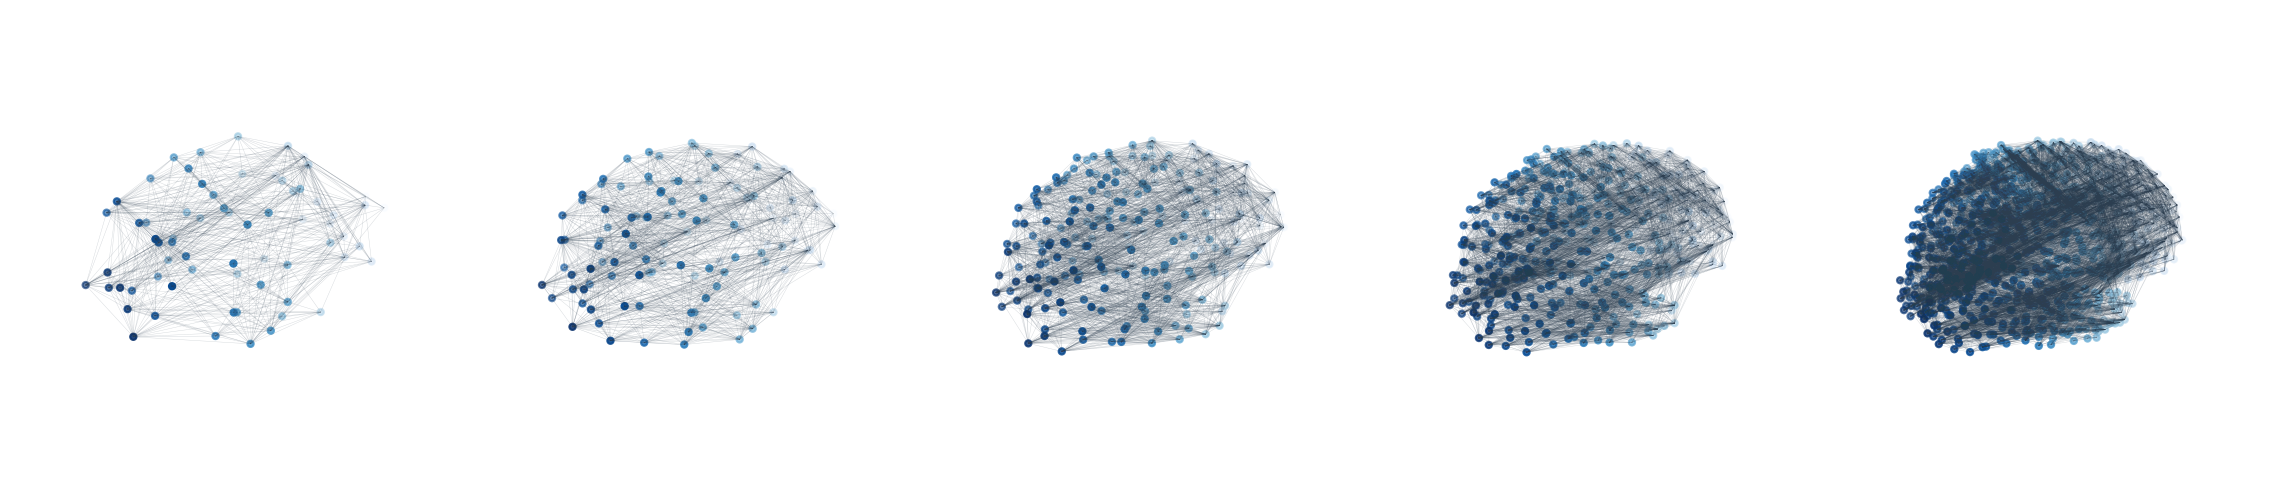

In [25]:
NIGHT_BLUE = "#2c3e50"
monochrome = "Blues"
scatter_kw_network = {}  
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C", "D", "E"]], figsize=(15, 5), subplot_kw=dict(projection="3d"), dpi=150
)
res_parcellation_values = [0, 1, 2, 3, 4]
for idx, res_parcellation in enumerate(res_parcellation_values):
    connectivity = data["LauConsensus"]["Matrices"][res_parcellation][0]
    coordinates = data["LauConsensus"]["Matrices"][res_parcellation][3]

    ax_key = chr(65 + idx)
    for i in range(connectivity.shape[0]):
        for j in range(i, connectivity.shape[1]):
            if connectivity[i, j] != 0:
                axes[ax_key].plot(
                    [coordinates[i, 0], coordinates[j, 0]],
                    [coordinates[i, 1], coordinates[j, 1]],
                    [coordinates[i, 2], coordinates[j, 2]],
                    c=NIGHT_BLUE,
                    alpha=0.2 + connectivity[i, j],
                    linewidth=0.2,
                )
    brain_plotter(
        np.array(coordinates[:, 0]),
        coordinates,
        axes[ax_key],
        view=(30, 60),  
        size=9,
        cmap=monochrome,
        scatter_kwargs=scatter_kw_network,
    )
    axes[ax_key].view_init(elev=30, azim=60)
fig.tight_layout(pad=0.1)
plt.show()


We can easliy see that in the different res parcelation values, the densities of the merrices are totaly different with each other. Because, res_parcellation value has affect on number of edges and possible number of edges. 

In [26]:
normalized_fc_matrices = {}
print("- Log Min-Max Normalized:")
for i, res_value in enumerate(res_parcellation_values, start=1):
    fc_matrix = data["LauConsensus"]["Matrices"][res_value][0]
    normalized_matrix = ut.log_minmax_normalize(fc_matrix)
    normalized_fc_matrices[f"Normalized_FC_Matrix_{i}"] = normalized_matrix
    density = ut.find_density(normalized_matrix)
    print(f"(res_parcellation={res_value})")
    print(f"Shape: {normalized_matrix.shape}")
    print(f"Density: {density:.4f}\n")

- Log Min-Max Normalized:
(res_parcellation=0)
Shape: (68, 68)
Density: 0.2768

(res_parcellation=1)
Shape: (114, 114)
Density: 0.2008

(res_parcellation=2)
Shape: (219, 219)
Density: 0.1193

(res_parcellation=3)
Shape: (448, 448)
Density: 0.0584

(res_parcellation=4)
Shape: (1000, 1000)
Density: 0.0243



## Fitting the SAR and LAM models with log_min_max normalized matricies on the SC' s and FC's which has different res_parcellation values

In [27]:
best_parameters_all_res = {}
best_parameters_all_lam_res = {}

for res_value in res_parcellation_values:
    # Load and normalize the matrix
    fc = data["LauConsensus"]["Matrices"][res_value][2]  # We use the different res values with for loop
    connectivity = data["LauConsensus"]["Matrices"][res_value][0]
    normalized_matrix = ut.log_minmax_normalize(connectivity) # In this analysis we used the log_min_max normalization technique because we discovered which normalization technique was better for our target in the last notebook. 
    
    # Fit SAR model
    sar_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]
    best_parameters_sar = ut.simple_fit(
        model=lambda **params: cor.sar(normalized_matrix, **params),
        X=fc,
        parameter_space=sar_parameter_space,
        n_jobs=-1
    )
    best_result_sar = max(best_parameters_sar, key=lambda x: x['correlation'])
    best_parameters_all_res[res_value] = {
        "best_parameters": best_parameters_sar,
        "best_result": best_result_sar
    }

    # Fit LAM model
    lam_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]
    best_parameters_lam = ut.simple_fit(
        model=lambda **params: cor.lam(normalized_matrix, **params),
        X=fc,
        parameter_space=lam_parameter_space,
        n_jobs=-1
    )
    best_result_lam = max(best_parameters_lam, key=lambda x: x['correlation'])
    best_parameters_all_lam_res[res_value] = {
        "best_parameters": best_parameters_lam,
        "best_result": best_result_lam
    }

C3PO noises: 100%|██████████| 500/500 [00:21<00:00, 23.35it/s]


In [28]:
# Extract results for SAR and LAM models
resolutions = list(best_parameters_all_res.keys())
sar_correlations = [best_parameters_all_res[res]['best_result']['correlation'] for res in resolutions]
lam_correlations = [best_parameters_all_lam_res[res]['best_result']['correlation'] for res in resolutions]

# Print extracted results
for res, sar_corr, lam_corr in zip(resolutions, sar_correlations, lam_correlations):
    print(f"Resolution: {res}")
    print(f"SAR Model Best Correlation: {sar_corr:.4f}")
    print(f"LAM Model Best Correlation: {lam_corr:.4f}")
    print()


Resolution: 0
SAR Model Best Correlation: 0.5589
LAM Model Best Correlation: 0.5829

Resolution: 1
SAR Model Best Correlation: 0.5161
LAM Model Best Correlation: 0.5268

Resolution: 2
SAR Model Best Correlation: 0.4703
LAM Model Best Correlation: 0.4804

Resolution: 3
SAR Model Best Correlation: 0.4194
LAM Model Best Correlation: 0.4138

Resolution: 4
SAR Model Best Correlation: 0.3635
LAM Model Best Correlation: 0.3366



Now we can easily create a bar chart to see which res_parcellation value performs best in which model

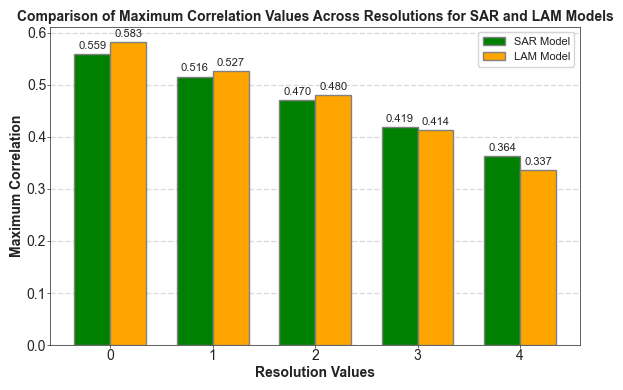

In [29]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
bar_width = 0.35
r1 = np.arange(len(resolutions))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(6, 4))

# SAR Model
plt.bar(r1, sar_correlations, color='green', width=bar_width, edgecolor='grey', label='SAR Model')

# LAM Model
plt.bar(r2, lam_correlations, color='orange', width=bar_width, edgecolor='grey', label='LAM Model')

plt.xlabel('Resolution Values', fontweight='bold')
plt.ylabel('Maximum Correlation', fontweight='bold')
plt.title('Comparison of Maximum Correlation Values Across Resolutions for SAR and LAM Models', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(resolutions))], resolutions)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding text labels
for i in range(len(sar_correlations)):
    plt.text(r1[i], sar_correlations[i] + 0.01, f"{sar_correlations[i]:.3f}", ha='center', fontsize=8)
    plt.text(r2[i], lam_correlations[i] + 0.01, f"{lam_correlations[i]:.3f}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()

And we can see how the correlation changes according to res values(for both SAR and LAM model)

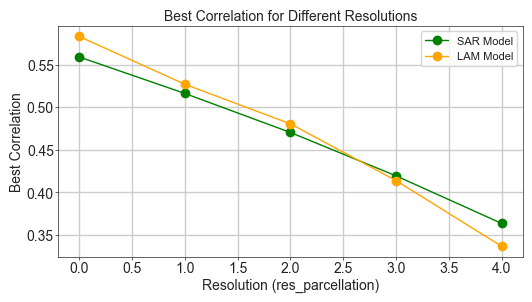

In [30]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
resolutions = list(best_parameters_all_res.keys())
sar_correlations = [data['best_result']['correlation'] for data in best_parameters_all_res.values()]
lam_correlations = [data['best_result']['correlation'] for data in best_parameters_all_lam_res.values()]

# Plot SAR Model Correlation vs Resolution
plt.figure(figsize=(6, 3))
plt.plot(resolutions, sar_correlations, marker='o', linestyle='-', color='green', label='SAR Model')
plt.plot(resolutions, lam_correlations, marker='o', linestyle='-', color='orange', label='LAM Model')
plt.xlabel('Resolution (res_parcellation)')
plt.ylabel('Best Correlation')
plt.title('Best Correlation for Different Resolutions')
plt.legend()
plt.grid(True)
plt.show()

We can easily see that the best correlation for both SAR and LAM model is with ‘res_parcellation = 0’, so we will use res value = 0 and apply our LAM model.  

In [31]:
res_parcellation = 0
fc = data["LauConsensus"]["Matrices"][res_parcellation][2] 
connectivity = data["LauConsensus"]["Matrices"][res_parcellation][0]

In [32]:
connectivity_log_min_max_normalize = ut.log_minmax_normalize(connectivity)

In [33]:
lam_parameter_space = [{'alpha': alpha} for alpha in np.linspace(0.01, 1.0, 500)]

best_parameters_forlam = ut.simple_fit(
    model=lambda **params: cor.lam(connectivity_log_min_max_normalize, **params),
    X=fc,
    parameter_space=lam_parameter_space,
    n_jobs=-1
)


C3PO noises: 100%|██████████| 500/500 [00:00<00:00, 4504.41it/s]


In [34]:
best_result_forlam = max(best_parameters_forlam, key=lambda x: x['correlation']) 
print("Best parameters:", best_result_forlam['alpha'])
print("Best correlation:", best_result_forlam['correlation'])

Best parameters: 0.12110220440881762
Best correlation: 0.5829481747524999


In [35]:
lam = cor.lam(connectivity_log_min_max_normalize, alpha=best_result_forlam['alpha']) 
lam

array([[ 1.09556925,  0.1354627 ,  0.05297222, ..., -0.16275883,
        -0.05167756, -0.21023853],
       [ 0.1354627 ,  1.05195703, -0.00307928, ..., -0.12858995,
        -0.04081914, -0.1651858 ],
       [ 0.05297222, -0.00307928,  1.02080546, ..., -0.05550843,
        -0.01997871, -0.06243259],
       ...,
       [-0.16275883, -0.12858995, -0.05550843, ...,  1.07008761,
         0.09262862,  0.10404819],
       [-0.05167756, -0.04081914, -0.01997871, ...,  0.09262862,
         1.02013564,  0.07014553],
       [-0.21023853, -0.1651858 , -0.06243259, ...,  0.10404819,
         0.07014553,  1.00167904]])

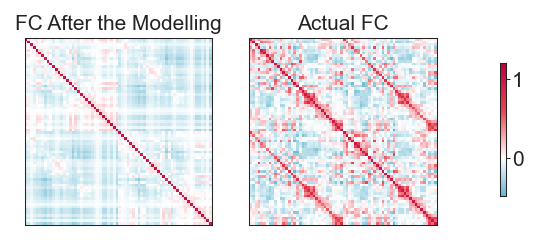

In [36]:
fig, axes = plt.subplot_mosaic([["A", "B"]], figsize=SMALL, dpi=150)
cbar_ax = fig.add_axes([1.02, 0.275, 0.01, 0.45])
sns.heatmap(
    lam,
    square=True,
    center=0,
    cmap=diverge_from_white,
    cbar=True,
    cbar_ax=cbar_ax,
    linewidths=0.0,
    yticklabels=False,
    xticklabels=False,
    ax = axes["A"],
    vmax=1.2 
)
sns.heatmap(
    fc,
    square=True,
    center=0,
    cmap=diverge_from_white,
    linewidths=0.0,
    cbar = True,
    cbar_ax=cbar_ax,
    yticklabels=False,
    xticklabels=False,
    ax = axes["B"],
    vmax=1.2 
)
axes["A"].title.set_text("FC After the Modelling")
axes["B"].title.set_text("Actual FC")
sns.despine(fig=fig, top=False, right=False, left=False,bottom=False)